In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# ========= Load data =========
df = pd.read_csv("./data/advertising.csv")

# Features x1, x2, x3 và nhãn y
X_raw = df[["TV", "Radio", "Newspaper"]].to_numpy(dtype=float) # shape: (m, 3)
y = df["Sales"].to_numpy(dtype=float) # shape: (m,)

m = X_raw.shape[0]

# Vectorization
# vec{x} = [1, x1, x2, x3]^T => thêm cột 1 ở đầu để bias nằm trong vec{w}
X = np.c_[np.ones(m), X_raw] # shape: (m, 4)
d = X.shape[1] # d = 4

print("m =", m, "| d =", d)
df.head()

m = 200 | d = 4


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


In [3]:
# ========= Model =========
# Ký hiệu vector hóa:
# vec{w} = [b, w1, w2, w3]^T
# vec{x} = [1, x1, x2, x3]^T

# f_{w,b}(vec{x}) = vec{w}^T vec{x}
# Với toàn bộ dữ liệu: y_hat = X @ vec{w}
def predict(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    return X @ w

In [4]:
# ========= Cost functions =========
# L^{(i)} = 1/2 (y_hat^{(i)} - y^{(i)})^2
# J_MSE(w) = (1/m) * sum_i L^{(i)} = (1/(2m)) * sum_i (e^{(i)})^2
def mse_cost(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    e = predict(X, w) - y
    return float(np.mean(0.5 * (e ** 2)))

# MAE: J_MAE(w) = (1/m) * sum_i |e^{(i)}|
def mae_cost(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    e = predict(X, w) - y
    return float(np.mean(np.abs(e)))

In [5]:
# ========= Initialization =========
# w khởi tạo ngẫu nhiên (0, 1) và b = 0
# Với vec{w} = [b, w1, w2, w3]^T  => w[0] chính là b
def init_w(d: int, seed: int = 42) -> np.ndarray:
    rng = np.random.default_rng(seed)
    w = rng.uniform(0.0, 1.0, size=d)
    w[0] = 0.0
    return w

In [6]:
# ========= SGD (MSE) =========
# Với 1 mẫu i:
# e^{(i)} = y_hat^{(i)} - y^{(i)}
# L^{(i)} = 1/2 (e^{(i)})^2
# dL/dw = e^{(i)} * vec{x}^{(i)}

# Cập nhật: w <- w - lr * grad
def train_sgd_mse(
    X: np.ndarray,
    y: np.ndarray,
    lr: float = 1e-5,
    epochs: int = 100,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray]:
    """
    Stochastic Gradient Descent với hàm mất mát MSE.

    Args:
        X: Ma trận đặc trưng đã thêm bias (m x d)
        y: Vector nhãn (m,)
        lr: Learning rate (alpha)
        epochs: Số epoch huấn luyện
        seed: Random seed để tái hiện

    Returns:
        w: Vector tham số cuối cùng (d,)
        losses: Mảng loss qua các epoch (epochs,)
    """
    m, d = X.shape
    rng = np.random.default_rng(seed)
    w = init_w(d, seed)
    losses: list[float] = []
    idx = np.arange(m)

    # Lưu loss ban đầu
    losses.append(mse_cost(X, y, w))

    for _ in range(epochs):
        # Shuffle để mỗi epoch duyệt mẫu theo thứ tự ngẫu nhiên
        rng.shuffle(idx)
        for i in idx:
            # Tính error cho mẫu thứ i
            e_i = float(X[i] @ w - y[i])
            # Tính gradient: dL/dw = e^{(i)} * x^{(i)}
            grad = e_i * X[i]
            # Cập nhật tham số
            w = w - lr * grad
        # Lưu loss sau mỗi epoch
        losses.append(mse_cost(X, y, w))

    return w, np.array(losses)

In [7]:
# ========= Batch GD (MSE) =========
# Với toàn bộ dữ liệu:
# e = Xw - y
# J_MSE(w) = (1/(2m)) sum e^2
# dJ/dw = (1/m) X^T e

# Cập nhật: w <- w - lr * (1/m) X^T e
def train_bgd_mse(
    X: np.ndarray,
    y: np.ndarray,
    lr: float = 1e-5,
    epochs: int = 100,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray]:
    """
    Batch Gradient Descent với hàm mất mát MSE.

    Args:
        X: Ma trận đặc trưng đã thêm bias (m x d)
        y: Vector nhãn (m,)
        lr: Learning rate (alpha)
        epochs: Số epoch huấn luyện
        seed: Random seed để tái hiện

    Returns:
        w: Vector tham số cuối cùng (d,)
        losses: Mảng loss qua các epoch (epochs,)
    """
    m, d = X.shape
    w = init_w(d, seed)
    losses: list[float] = []

    # Lưu loss ban đầu
    losses.append(mse_cost(X, y, w))

    for _ in range(epochs):
        # Tính error vector cho toàn bộ dữ liệu
        e = X @ w - y
        # Tính gradient: dJ/dw = (1/m) X^T e
        grad = (X.T @ e) / m
        # Cập nhật tham số
        w = w - lr * grad
        # Lưu loss sau mỗi epoch
        losses.append(mse_cost(X, y, w))

    return w, np.array(losses)

In [8]:
# ========= SGD (MAE) =========
# Với 1 mẫu i:
# L^{(i)} = |e^{(i)}|
# dL/dw = sign(e^{(i)}) * vec{x}^{(i)}
# Trong đó sign(0) = 0

# Cập nhật: w <- w - lr * sign(e^{(i)}) * x^{(i)}
def train_sgd_mae(
    X: np.ndarray,
    y: np.ndarray,
    lr: float = 1e-5,
    epochs: int = 100,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray]:
    """
    Stochastic Gradient Descent với hàm mất mát MAE.

    Args:
        X: Ma trận đặc trưng đã thêm bias (m x d)
        y: Vector nhãn (m,)
        lr: Learning rate (alpha)
        epochs: Số epoch huấn luyện
        seed: Random seed để tái hiện

    Returns:
        w: Vector tham số cuối cùng (d,)
        losses: Mảng loss qua các epoch (epochs,)
    """
    m, d = X.shape
    rng = np.random.default_rng(seed)
    w = init_w(d, seed)
    losses: list[float] = []
    idx = np.arange(m)

    # Lưu loss ban đầu
    losses.append(mae_cost(X, y, w))

    for _ in range(epochs):
        # Shuffle để mỗi epoch duyệt mẫu theo thứ tự ngẫu nhiên
        rng.shuffle(idx)
        for i in idx:
            # Tính error cho mẫu thứ i
            e_i = float(X[i] @ w - y[i])
            # Tính sign(e^{(i)}), với quy ước sign(0) = 0
            s = 0.0 if e_i == 0.0 else (1.0 if e_i > 0.0 else -1.0)
            # Tính gradient: dL/dw = sign(e^{(i)}) * x^{(i)}
            grad = s * X[i]
            # Cập nhật tham số
            w = w - lr * grad
        # Lưu loss sau mỗi epoch
        losses.append(mae_cost(X, y, w))

    return w, np.array(losses)

In [9]:
# ========= Batch GD (MAE) =========
# e = Xw - y
# J_MAE(w) = (1/m) sum |e|
# dJ/dw = (1/m) X^T sign(e)

# Cập nhật: w <- w - lr * (1/m) X^T sign(e)
def train_bgd_mae(
    X: np.ndarray,
    y: np.ndarray,
    lr: float = 1e-5,
    epochs: int = 100,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray]:
    """
    Batch Gradient Descent với hàm mất mát MAE.

    Args:
        X: Ma trận đặc trưng đã thêm bias (m x d)
        y: Vector nhãn (m,)
        lr: Learning rate (alpha)
        epochs: Số epoch huấn luyện
        seed: Random seed để tái hiện

    Returns:
        w: Vector tham số cuối cùng (d,)
        losses: Mảng loss qua các epoch (epochs,)
    """
    m, d = X.shape
    w = init_w(d, seed)
    losses: list[float] = []

    # Lưu loss ban đầu
    losses.append(mae_cost(X, y, w))

    for _ in range(epochs):
        # Tính error vector cho toàn bộ dữ liệu
        e = X @ w - y
        # Tính sign của error vector (np.sign(0) = 0 tự động)
        s = np.sign(e)
        # Tính gradient: dJ/dw = (1/m) X^T sign(e)
        grad = (X.T @ s) / m
        # Cập nhật tham số
        w = w - lr * grad
        # Lưu loss sau mỗi epoch
        losses.append(mae_cost(X, y, w))

    return w, np.array(losses)

In [10]:
lr = 1e-5
epochs = 100
seed = 42

w_sgd_mse, loss_sgd_mse = train_sgd_mse(X, y, lr=lr, epochs=epochs, seed=seed)
w_bgd_mse, loss_bgd_mse = train_bgd_mse(X, y, lr=lr, epochs=epochs, seed=seed)

w_sgd_mae, loss_sgd_mae = train_sgd_mae(X, y, lr=lr, epochs=epochs, seed=seed)
w_bgd_mae, loss_bgd_mae = train_bgd_mae(X, y, lr=lr, epochs=epochs, seed=seed)

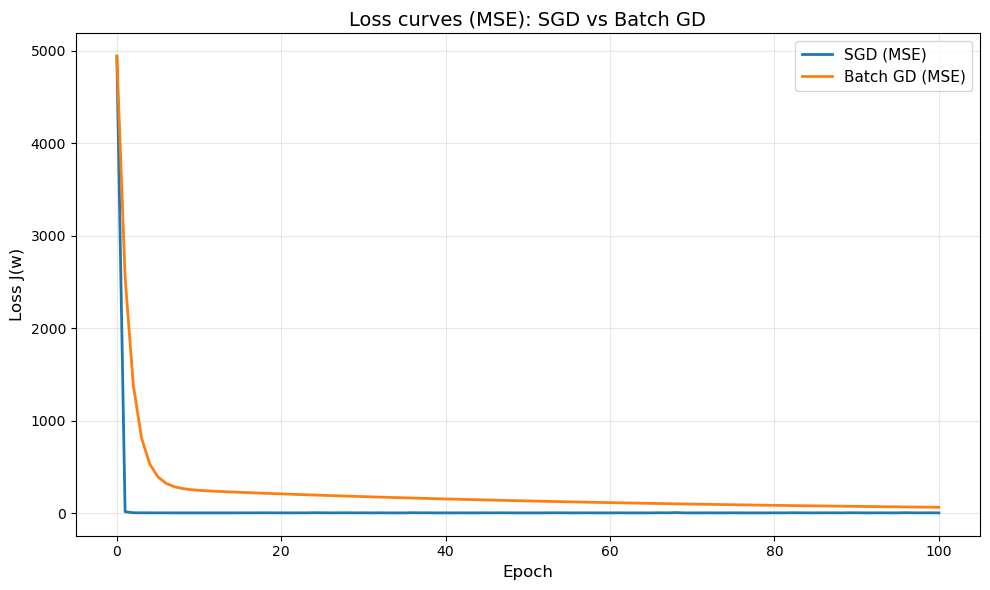

In [11]:
# ========= Plot MSE (SGD vs Batch GD) =========
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_sgd_mse)), loss_sgd_mse, label="SGD (MSE)", linewidth=2)
plt.plot(np.arange(len(loss_bgd_mse)), loss_bgd_mse, label="Batch GD (MSE)", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss J(w)", fontsize=12)
plt.title("Loss curves (MSE): SGD vs Batch GD", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

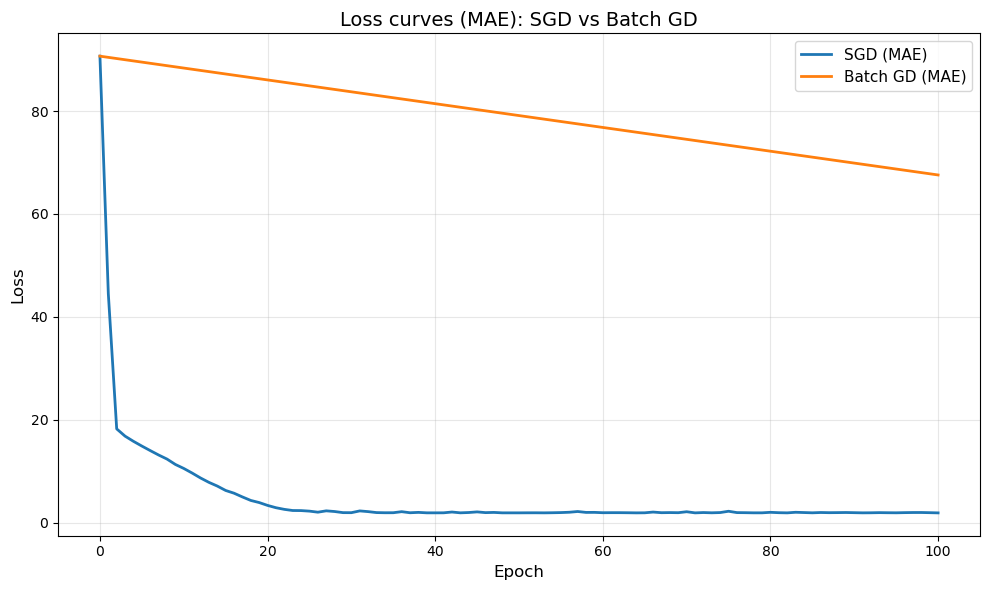

In [12]:
# ========= Plot MAE (SGD vs Batch GD) =========
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_sgd_mae)), loss_sgd_mae, label="SGD (MAE)", linewidth=2)
plt.plot(np.arange(len(loss_bgd_mae)), loss_bgd_mae, label="Batch GD (MAE)", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss curves (MAE): SGD vs Batch GD", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
# ========= Results =========
def pretty_w(name: str, w: np.ndarray) -> None:
    b, w1, w2, w3 = w
    print(name)
    print("b  =", b)
    print("w1 =", w1)
    print("w2 =", w2)
    print("w3 =", w3)
    print()

pretty_w("SGD (MSE)", w_sgd_mse)
pretty_w("Batch GD (MSE)", w_bgd_mse)
pretty_w("SGD (MAE)", w_sgd_mae)
pretty_w("Batch GD (MAE)", w_bgd_mae)

SGD (MSE)
b  = 0.11967383063472119
w1 = 0.06516511957164679
w2 = 0.1616711041137433
w3 = 0.027222512582367613

Batch GD (MSE)
b  = -0.0070478126467513925
w1 = -0.013710156164045239
w2 = 0.5354607694230217
w3 = 0.23933233760833886

SGD (MAE)
b  = 0.026359999999999096
w1 = 0.06469043975205598
w2 = 0.17343991991137472
w3 = 0.027462029059365158

Batch GD (MAE)
b  = -0.001000000000000002
w1 = 0.2918359397520526
w2 = 0.8353339199113818
w3 = 0.666814029059359

